<a href="https://colab.research.google.com/github/uditkaushikk555/EfficientNet-Based-Cassava-Leaf-Disease-Classification/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.75G/5.76G [01:16<00:00, 67.7MB/s]
100% 5.76G/5.76G [01:16<00:00, 80.6MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cassava-leaf-disease-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#%% IMPORTING LIBRARIES

import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Defining the working directories

# work_dir = '/content/cassava-leaf-disease-classification.zip'
# os.listdir(work_dir)
train_path = '/content/train_images'

In [ ]:
#%% IMPORTING DATA

# Importing train.csv

data = pd.read_csv('train.csv')
print(Counter(data['label'])) # Checking the frequencies of the labels

Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


<Axes: >

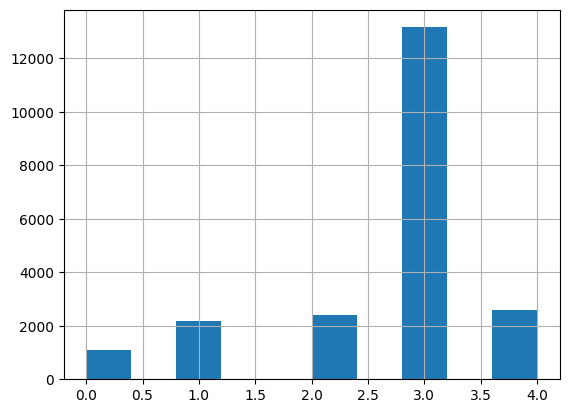

In [ ]:
data['label'].hist()

In [ ]:
# Importing the json file with labels

f = open(  'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset
data['class_name'] = data.label.map(real_labels)
print(data.head(10))
print(data['class_name'].unique())

         image_id  label                           class_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)
5  1000837476.jpg      3         Cassava Mosaic Disease (CMD)
6  1000910826.jpg      2           Cassava Green Mottle (CGM)
7  1001320321.jpg      0       Cassava Bacterial Blight (CBB)
8  1001723730.jpg      4                              Healthy
9  1001742395.jpg      3         Cassava Mosaic Disease (CMD)
['Cassava Bacterial Blight (CBB)' 'Cassava Mosaic Disease (CMD)'
 'Cassava Brown Streak Disease (CBSD)' 'Cassava Green Mottle (CGM)'
 'Healthy']


In [ ]:
def showImages(images):

    # Extract 16 random images from it
    random_images = [np.random.choice(images) for i in range(16)]

    # Adjust the size of your images
    plt.figure(figsize=(16,12))

    # Iterate and plot random images
    for i in range(16):
        plt.subplot(4,4, i + 1)
        img = plt.imread(train_path+'/'+random_images[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()

In [ ]:
mask = data['label'] ==4
classHealthy = data[mask]

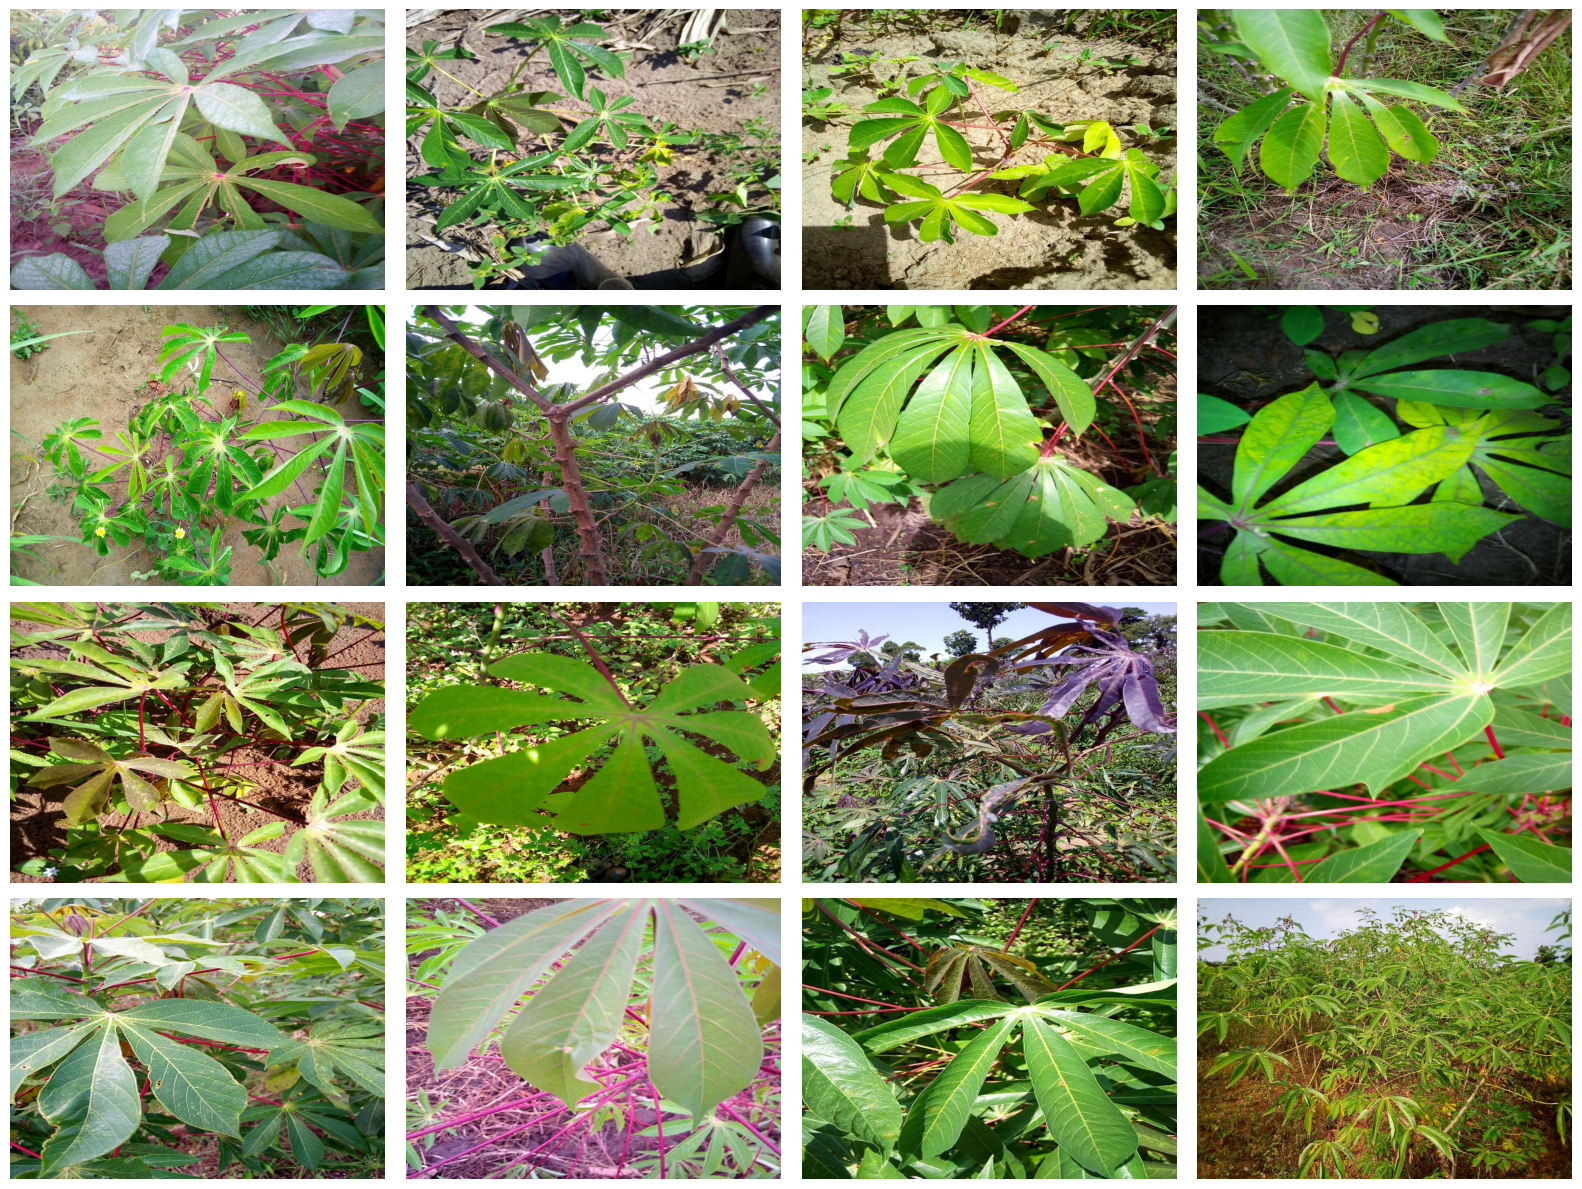

In [ ]:
showImages(classHealthy['image_id'])

In [ ]:
mask = data['label'] ==3
classCMD = data[mask]

In [ ]:
showImages(classCMD['image_id'])

In [ ]:
mask = data['label'] ==2
classCGM = data[mask]

In [ ]:
showImages(classCGM['image_id'])

In [ ]:
mask = data['label'] ==1
classCBSD = data[mask]

In [ ]:
showImages(classCBSD['image_id'])

In [ ]:
mask = data['label'] ==0
classCBB = data[mask]

In [ ]:
showImages(classCBB['image_id'])

In [ ]:
class0 = classCBB.sample(frac=0.99)
class1 = classCBSD.sample(frac=0.9)
class2 = classCGM.sample(frac=0.9)
class3 = classCMD.sample(frac=0.9)
class4 = classHealthy.sample(frac=0.9)




frames=[class0,class1,class2,class3,class4]
finalData = pd.concat(frames)
finalData.head(10)
print(len(finalData))

# Spliting the data
from sklearn.model_selection import train_test_split

train,val = train_test_split(finalData, test_size = 0.05, random_state = 42, stratify = finalData['class_name'])

# Importing the data using ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 300
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5

datagen = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 60,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

train_set = datagen.flow_from_dataframe(train,
                         directory = train_path,
                         seed=42,
                         x_col = 'image_id',
                         y_col = 'class_name',
                         target_size = size,
                         class_mode = 'categorical',
                         interpolation = 'nearest',
                         shuffle = True,
                         batch_size = 32)

val_set = datagen.flow_from_dataframe(val,
                         directory = train_path,
                         seed=42,
                         x_col = 'image_id',
                         y_col = 'class_name',
                         target_size = size,
                         class_mode = 'categorical',
                         interpolation = 'nearest',
                         shuffle = True,
                         batch_size = 32)



19354
Found 18386 validated image filenames belonging to 5 classes.
Found 968 validated image filenames belonging to 5 classes.


In [ ]:

def create_model():

    model = Sequential()
    # initialize the model with input shape as (224,224,3)
    model.add(tf.keras.applications.EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet' ))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.7))
    model.add(Dense(32, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.7))
    model.add(Dense(n_CLASS, activation = 'softmax'))

    return model

leaf_model = create_model()
leaf_model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 10, 10, 1536)      10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

In [ ]:
EPOCHS = 5
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

In [ ]:
#%% FITTING THE MODEL

def Model_fit():

    #leaf_model = None

    leaf_model = create_model()

    '''Compiling the model'''

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' )

    leaf_model.compile(optimizer = Adam(learning_rate = 2e-4),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'

    # Stop training when the val_loss has stopped decreasing for 5 epochs.
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5,
                       restore_best_weights=True, verbose=1)

    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("Cassava_best_modelEffNetB3.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')

    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.3,
                                  patience = 3,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)

    history = leaf_model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = 32,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[es, checkpoint_cb, reduce_lr])

    leaf_model.save('Cassava_modelEffNetB3'+'.h5')

    return history

In [ ]:
history = Model_fit()

Epoch 1/5
574/574 [==============================] - ETA: 0s - loss: 1.0289 - categorical_accuracy: 0.6080

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


574/574 [==============================] - 946s 2s/step - loss: 1.0289 - categorical_accuracy: 0.6080 - val_loss: 0.6613 - val_categorical_accuracy: 0.7948 - lr: 2.0000e-04
Epoch 2/5
574/574 [==============================] - 839s 1s/step - loss: 0.8085 - categorical_accuracy: 0.7109 - val_loss: 0.5392 - val_categorical_accuracy: 0.8323 - lr: 2.0000e-04
Epoch 3/5
574/574 [==============================] - 847s 1s/step - loss: 0.7290 - categorical_accuracy: 0.7494 - val_loss: 0.5196 - val_categorical_accuracy: 0.8365 - lr: 2.0000e-04
Epoch 4/5
574/574 [==============================] - 847s 1s/step - loss: 0.6730 - categorical_accuracy: 0.7672 - val_loss: 0.4974 - val_categorical_accuracy: 0.8417 - lr: 2.0000e-04
Epoch 5/5
574/574 [==============================] - 843s 1s/step - loss: 0.6455 - categorical_accuracy: 0.7814 - val_loss: 0.4435 - val_categorical_accuracy: 0.8469 - lr: 2.0000e-04


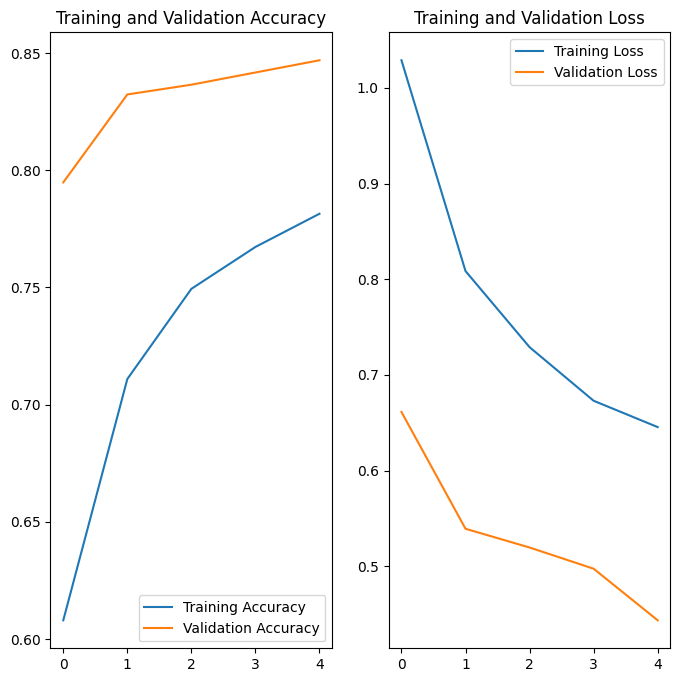

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:

import keras

final_model = keras.models.load_model('Cassava_best_modelEffNetB3.h5')


In [ ]:
# Importing the json file with labels
# work_dir = '/content/cassava-leaf-disease-classification.zip'
f = open('label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset
data['class_name'] = data.label.map(real_labels)

class0 = classCBB.sample(frac=0.99)
class1 = classCBSD.sample(frac=0.7)
class2 = classCGM.sample(frac=0.7)
class3 = classCMD.sample(frac=0.7)
class4 = classHealthy.sample(frac=0.7)




frames=[class0,class1,class2,class3,class4]
finalData = pd.concat(frames)
finalData.head(10)
print(len(finalData))

# Spliting the data
from sklearn.model_selection import train_test_split

train,val = train_test_split(finalData, test_size = 0.1, random_state = 40, stratify = finalData['class_name'])

# Importing the data using ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 300
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5

datagen = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range =40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

train_set = datagen.flow_from_dataframe(train,
                         directory = train_path,
                         seed= 40,
                         x_col = 'image_id',
                         y_col = 'class_name',
                         target_size = size,
                         #color_mode="rgb",
                         class_mode = 'categorical',
                         interpolation = 'nearest',
                         shuffle = True,
                         batch_size = 32)
valDatagen = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
                    )

val_set = valDatagen.flow_from_dataframe(val,
                         directory = train_path,
                         seed=40,
                         x_col = 'image_id',
                         y_col = 'class_name',
                         target_size = size,
                         #color_mode="rgb",
                         class_mode = 'categorical',
                         interpolation = 'nearest',
                         shuffle = True,
                         batch_size = 32)



15293
Found 13763 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.


In [ ]:
EPOCHS = 3
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

In [ ]:
def Model_fit1(model):

    leaf_model = model


    '''Compiling the model'''

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.01,
                                                   name='categorical_crossentropy' )

    leaf_model.compile(optimizer =  Adam(learning_rate = 2e-4),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'

    # Stop training when the val_loss has stopped decreasing for 5 epochs.
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5,
                       restore_best_weights=True, verbose=1)

    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("Cassava_best_modelEffNetB3v3.h5",
                                    save_best_only=True,
                                    monitor = 'categorical_accuracy',
                                    mode='max')

    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.1,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)

    history = leaf_model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = 32,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[es, checkpoint_cb, reduce_lr])

    leaf_model.save('Cassava_modelEffNetB3v3'+'.h5')

    return history

In [ ]:
Model_fit1(final_model)

Epoch 1/3
430/430 [==============================] - ETA: 0s - loss: 0.7046 - categorical_accuracy: 0.7738

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


430/430 [==============================] - 694s 1s/step - loss: 0.7046 - categorical_accuracy: 0.7738 - val_loss: 0.4908 - val_categorical_accuracy: 0.8471 - lr: 2.0000e-04
Epoch 2/3
430/430 [==============================] - 622s 1s/step - loss: 0.6598 - categorical_accuracy: 0.7964 - val_loss: 0.5363 - val_categorical_accuracy: 0.8305 - lr: 2.0000e-04
Epoch 3/3
430/430 [==============================] - 624s 1s/step - loss: 0.6463 - categorical_accuracy: 0.7993 - val_loss: 0.4623 - val_categorical_accuracy: 0.8590 - lr: 2.0000e-04


**PREDICTION**

In [ ]:
#%% IMPORTING LIBRARIES

import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

# Defining the working directories

# work_dir = '../input/cassava-leaf-disease-classification/'
# os.listdir(work_dir)
train_path = '/content/train_images'

In [ ]:
# Evaluating the model

import keras

#final_model1 = keras.models.load_model('../input/leafclasseffnet/Cassava_best_modelEffNetB4v5.h5')
final_model2 = keras.models.load_model('/content/Cassava_modelEffNetB3v3.h5')

In [ ]:
import glob

TEST_DIR = '/content/test_images'
test_images = glob.glob(os.path.join(TEST_DIR, "*.jpg")) + glob.glob(os.path.join(TEST_DIR, "*.png"))
predictions = []
IMG_SIZE = 380
IMG_SIZE1 = 300
size = (IMG_SIZE,IMG_SIZE)
size1= (IMG_SIZE1,IMG_SIZE1)
for image in test_images:
    '''
    img = Image.open(TEST_DIR + image)
    img = img.resize(size)
    img = np.expand_dims(img, axis=0)
    prediction1 = final_model1.predict(img)
    print(prediction1)
    '''
    img1 = Image.open(os.path.join(TEST_DIR, image))
    img1 = img1.resize(size1)
    img1 = np.expand_dims(img1, axis=0)
    prediction2 = final_model2.predict(img1)
    print(prediction2)
    #result = prediction1 + prediction2
    #print(result)
    #predictions.extend(result.argmax(axis = 1))
    predictions.extend(prediction2.argmax(axis = 1))

1/1 [==============================] - 0s 32ms/step
[[0.07191101 0.03221345 0.02506247 0.05000533 0.8208077 ]]
1/1 [==============================] - 0s 29ms/step
[[4.0492920e-09 7.2402298e-07 6.9513471e-06 9.9999082e-01 1.5230263e-06]]
1/1 [==============================] - 0s 30ms/step
[[0.01845513 0.04608409 0.84639436 0.04629156 0.04277481]]


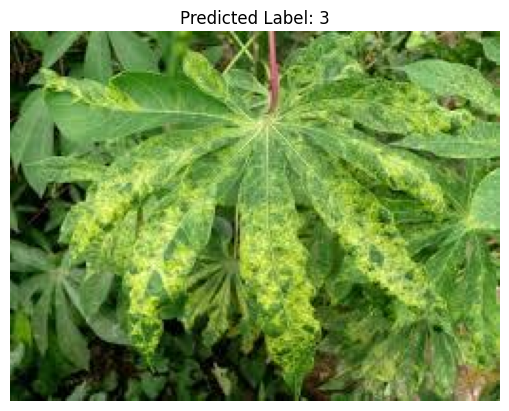

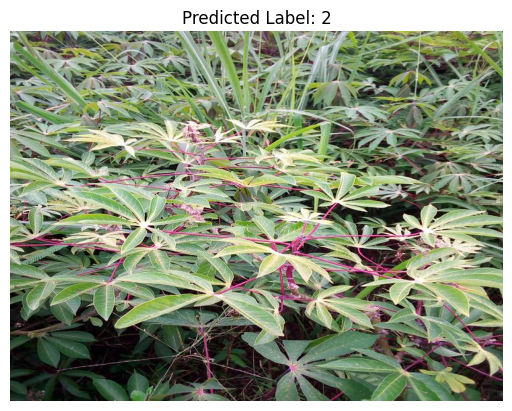

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already imported necessary libraries and defined variables

# Iterate over each test image and its corresponding prediction
for image_path, prediction in zip(test_images, predictions):
    # Load and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')

    # Set the title as the predicted label
    plt.title(f'Predicted Label: {prediction}')

    # Show the image with the predicted label
    plt.show()
